# Import needed libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization, concatenate, Cropping2D
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

2023-12-29 00:24:47.582459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 00:24:47.582614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 00:24:47.665371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 00:24:47.850783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 00:24:50.458405: W tensorflow/compiler/tf2

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


2023-12-29 00:24:56.690599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:24:56.992275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:24:56.992433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:00.189708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:00.189788: I external/local_xla/xla/stream_executor

# Load Data

In [4]:
trainingset = 'train'
testset = 'test'

batch_size = 16

"""
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.3,\
    rotation_range=30,\
    width_shift_range=0.4,\
    height_shift_range=0.4,\
    horizontal_flip=True,\
    vertical_flip=False
    )
"""
train_datagen = ImageDataGenerator()

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## Data distribution

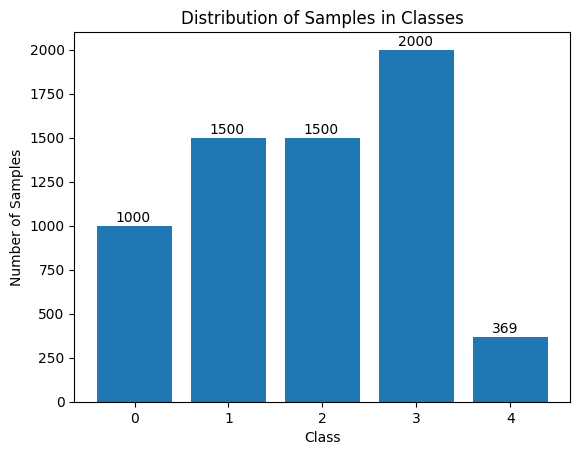

In [5]:
# Count the number of samples 
class_counts = {class_name: 0 for class_name in np.unique(train_generator.classes)}
for label in train_generator.classes:
    class_counts[label] += 1
    if sum(class_counts.values()) >= num_samples:
        break

# Plot the distribution
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Classes')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 25, yval,)
plt.show()


# Model I

In [5]:

def ModelI(input_shape, num_classes, regl2 = 0.01, lr=0.001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=32, input_shape=input_shape, kernel_size=(5,5),\
                     strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # Dense Layer
    model.add(Dense(128, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model1 = ModelI(input_shape,num_classes)
model1.summary()

# define the callback
callback1 = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5)

# history of results (set to None when initializing a new mdoel)
history = None


2023-12-28 06:58:35.007744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 06:58:35.007993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 06:58:35.008109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 06:58:35.008639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 06:58:35.008704: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        2432      
                                                                 
 activation (Activation)     (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

## Train

In [6]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [11]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
#val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs


try:
    # Record the start time
    #start_time = time.time()
    h = model1.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    #class_weight=class_weight_dict,\
                    callbacks=[callback1]
                    #validation_data=test_generator,\
                    #validation_steps=val_steps
                    )
    # Record the end time
    # end_time = time.time()
except KeyboardInterrupt:
    pass

# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    #history['val_loss'].extend(h.history['val_loss'])
    #history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))

# Calculate and print the training time
#training_time = end_time - start_time
#print(f"Training time: {training_time} seconds")

Epoch 1/100
398/398 [==============================] - 16s 38ms/step - loss: 1.3830 - accuracy: 0.5607
Epoch 2/100
398/398 [==============================] - 16s 39ms/step - loss: 1.4524 - accuracy: 0.5591
Epoch 3/100
398/398 [==============================] - 15s 38ms/step - loss: 1.4394 - accuracy: 0.5571
Epoch 4/100
398/398 [==============================] - 15s 38ms/step - loss: 1.3598 - accuracy: 0.5637
Epoch 5/100
398/398 [==============================] - 16s 39ms/step - loss: 1.3672 - accuracy: 0.5604
Epoch 6/100
398/398 [==============================] - 18s 43ms/step - loss: 1.3972 - accuracy: 0.5676
Epoch 7/100
398/398 [==============================] - 25s 63ms/step - loss: 1.3600 - accuracy: 0.5706
Epoch 8/100
398/398 [==============================] - 15s 39ms/step - loss: 1.3490 - accuracy: 0.5715
Epoch 9/100
398/398 [==============================] - 15s 39ms/step - loss: 1.3585 - accuracy: 0.5805
Epoch 10/100
398/398 [==============================] - 15s 39ms/step - l

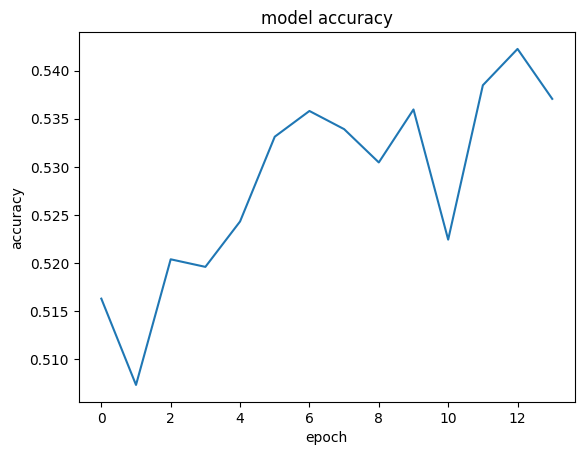

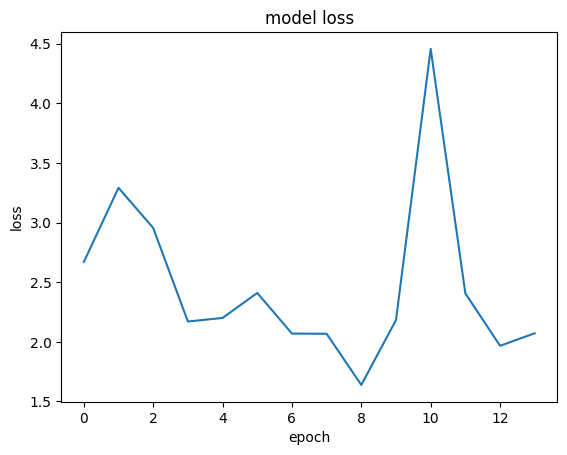

In [15]:
# summarize history for accuracy
plt.plot(history['accuracy'])
#plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
#plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left') #label of line
plt.show()

### Save model

In [10]:
models_dir = 'models'
modelname = 'model1_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model1,model1.history)


/home/gioia/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully on file models/model1_24_epochs.h5

History saved successfully on file models/model1_24_epochs_history.pkl



## Evaluate

In [ ]:
#model = tf.keras.models.load_model('models/model1_NoAug_20_epochs.h5')

In [12]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = model1.evaluate(test_generator,verbose=1,steps=val_steps)
pred = model1.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))


172
172/172 [==============================] - 56s 328ms/step
Test loss: 1.233813
Test accuracy: 0.640597
              precision    recall  f1-score   support

           0     0.3030    0.3008    0.3019       133
           1     0.3304    0.6764    0.4439       275
           2     0.4755    0.6700    0.5562       406
           3     0.8540    0.6661    0.7484      1896
           4     0.0000    0.0000    0.0000        39

    accuracy                         0.6406      2749
   macro avg     0.3926    0.4626    0.4101      2749
weighted avg     0.7069    0.6406    0.6574      2749



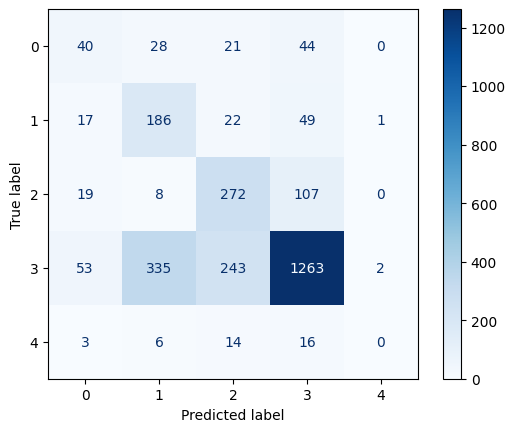

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3                ->  1                 	335 	12.19 % 
3                ->  2                 	243 	8.84 % 
2                ->  3                 	107 	3.89 % 
3                ->  0                 	53 	1.93 % 
1                ->  3                 	49 	1.78 % 
0                ->  3                 	44 	1.60 % 
0                ->  1                 	28 	1.02 % 
1                ->  2                 	22 	0.80 % 
0                ->  2                 	21 	0.76 % 
2                ->  0                 	19 	0.69 % 
1                ->  0                 	17 	0.62 % 
4                ->  3                 	16 	0.58 % 
4                ->  2                 	14 	0.51 % 
2                ->  1                 	8 	0.29 % 
4                ->  1                 	6 	0.22 % 
4                ->  0                 	3 	0.11 % 
3                ->  4                 	2 	0.

: 

In [13]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

# Model II

In [6]:
# Define the composite model 
def composite_model(input_shape, num_classes, upper_crop, lower_crop,lr = 0.001):
    input_layer = Input(input_shape) 

    # Upper part
    upper_part = Cropping2D(cropping=upper_crop)(input_layer)
    upper_model = Conv2D(32, (3, 3), activation='relu')(upper_part)
    upper_model = MaxPooling2D((2, 2))(upper_model)
    upper_model = Conv2D(64, (3, 3), activation='relu')(upper_model)
    upper_model = Flatten()(upper_model)
    upper_model = Dense(128, activation='relu')(upper_model)

    # Lower part
    lower_part = Cropping2D(cropping=lower_crop)(input_layer)
    lower_model = Conv2D(32, (3, 3), activation='relu')(lower_part)
    lower_model = MaxPooling2D((2, 2))(lower_model)
    lower_model = Conv2D(64, (3, 3), activation='relu')(lower_model)
    lower_model = Flatten()(lower_model)
    lower_model = Dense(128, activation='relu')(lower_model)

    # All parts


    # Concatenate the outputs of the upper and lower models
    merged = concatenate([upper_model, lower_model])

    # Add additional layers for the combined model
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.4)(merged)
    output_layer = Dense(num_classes, activation='softmax')(merged)  

    # Create and compile the composite model
    adam = optimizers.Adam(learning_rate=lr)
    composite_model = Model(inputs=input_layer, outputs=output_layer)
    composite_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return composite_model

# Instantiate the composite model
upper_crop = ((0, 48), (0, 0))  # Adjust based on your specific image dimensions
lower_crop = ((48, 0), (0, 0))  # Adjust based on your specific image dimensions
composite_model = composite_model(input_shape, num_classes, upper_crop, lower_crop)

# Print the model summary
composite_model.summary()

# define the callback
callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5)

history = None

2023-12-29 00:25:01.636464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:01.636834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:01.637024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:01.637563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-29 00:25:01.637660: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 cropping2d (Cropping2D)     (None, 48, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 cropping2d_1 (Cropping2D)   (None, 48, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 46, 94, 32)           896       ['cropping2d[0][0]']          
                                                                                              

## Train

In [7]:
%%time
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 100  # sets number of epochs

h = composite_model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    #class_weight=class_weight_dict,\
                    callbacks=[callback2]
                    #validation_data=test_generator,\
                    #validation_steps=val_steps
                    )


# append current history
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

print("number of epochs trained: %d" %len(history['loss']))


Epoch 1/100


2023-12-29 00:25:06.345560: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-29 00:25:09.724418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 00:25:11.933517: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 00:25:13.120554: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efa27676310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 00:25:13.120659: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2023-12-29 00:25:13.205288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703805913.477651    3424 device_compiler.h:1

398/398 [==============================] - 40s 62ms/step - loss: 4.6907 - accuracy: 0.5032
Epoch 2/100
398/398 [==============================] - 24s 60ms/step - loss: 1.2160 - accuracy: 0.5489
Epoch 3/100
398/398 [==============================] - 24s 59ms/step - loss: 1.1501 - accuracy: 0.5747
Epoch 4/100
398/398 [==============================] - 24s 59ms/step - loss: 1.0815 - accuracy: 0.6016
Epoch 5/100
398/398 [==============================] - 24s 59ms/step - loss: 1.0228 - accuracy: 0.6230
Epoch 6/100
398/398 [==============================] - 24s 59ms/step - loss: 1.0518 - accuracy: 0.6123
Epoch 7/100
398/398 [==============================] - 24s 60ms/step - loss: 1.1379 - accuracy: 0.5999
Epoch 8/100
398/398 [==============================] - 24s 59ms/step - loss: 1.0172 - accuracy: 0.6247
Epoch 9/100
398/398 [==============================] - 24s 59ms/step - loss: 0.9359 - accuracy: 0.6551
Epoch 10/100
398/398 [==============================] - 24s 59ms/step - loss: 0.9084 

## Evaluate

In [10]:
val_steps=test_generator.n//test_generator.batch_size+1
print(val_steps)
loss, acc = composite_model.evaluate(test_generator,verbose=1,steps=val_steps)
pred = composite_model.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1)
#print(pred)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)
print(classification_report(test_generator.classes, pred, target_names=classnames,digits=4))

172
172/172 [==============================] - 2s 9ms/step
Test loss: 10.585795
Test accuracy: 0.400146
              precision    recall  f1-score   support

           0     0.1055    0.3459    0.1617       133
           1     0.2347    0.5564    0.3301       275
           2     0.3491    0.5813    0.4362       406
           3     0.8119    0.3460    0.4852      1896
           4     0.0508    0.2308    0.0833        39

    accuracy                         0.4001      2749
   macro avg     0.3104    0.4121    0.2993      2749
weighted avg     0.6408    0.4001    0.4411      2749



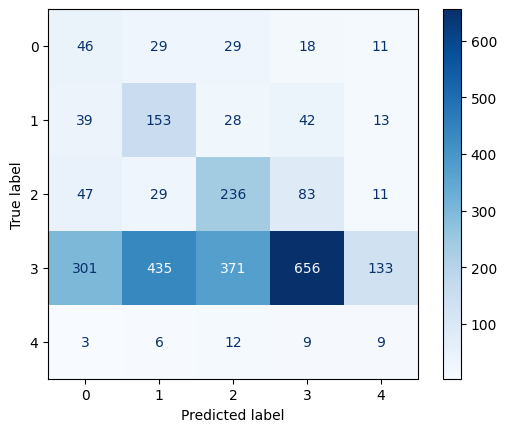

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
3                ->  1                 	435 	15.82 % 
3                ->  2                 	371 	13.50 % 
3                ->  0                 	301 	10.95 % 
3                ->  4                 	133 	4.84 % 
2                ->  3                 	83 	3.02 % 
2                ->  0                 	47 	1.71 % 
1                ->  3                 	42 	1.53 % 
1                ->  0                 	39 	1.42 % 
0                ->  1                 	29 	1.05 % 
2                ->  1                 	29 	1.05 % 
0                ->  2                 	29 	1.05 % 
1                ->  2                 	28 	1.02 % 
0                ->  3                 	18 	0.65 % 
1                ->  4                 	13 	0.47 % 
4                ->  2                 	12 	0.44 % 
2                ->  4                 	11 	0.40 % 
0                ->  4                 

In [9]:
ytest = test_generator.classes
cm = confusion_matrix(ytest, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classnames)
disp.plot(cmap=plt.cm.Blues)
plt.show()


conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))